# Counting Cells, Detecting Transients and Working Out Signal to Noise Ratios

In [58]:
import re
import pandas as pd
import scipy.stats
import scipy.signal as signal
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


### ROI by size 

So this counts the number of cells actually detected. It does so by first eliminating ROI that are too large and then ROI that are too small

Circulaity gives an indication of how round the shapes are.

    circularity = 4pi x (area/(perimeter^2))
    
https://imagej.nih.gov/ij/docs/guide/146-30.html

I still have to decide on a suitable circularity value. I am not so sure how to decide this. Perhaps I can check all the cells that have signal responses and then check their circulairty and then use the average of what I can getfrom that

In [59]:
def circularity_test_on_passed_ferret(ferret_ar, df):
    import re
    passed_feret_roinum = []
    for roi in ferret_ar:
        passed_feret_roinum.append(re.findall('\d+', roi )) 
    min_circ = 0.5
    circ_df = df.filter(regex=("Circ.*"), axis=1)
    circ_columns = []
    for column in circ_df.columns:
        if re.findall('\d+', column ) in passed_feret_roinum:
            circ_columns.append(column)

    passedferret_circdf = circ_df.filter(circ_columns, axis=1)
    #accepted_circ = [circ for circ in circ_df.iloc[1] if circ > min_circ]
    accepted_circvals = passedferret_circdf.columns[(passedferret_circdf > min_circ).iloc[0]]
    #print ("Number of cells regions originally: ", len(circ_df.iloc[1]))
    #print ("Number of cells with suitable circularity and feret number: ", len(accepted_circvals))
    return accepted_circvals

https://imagej.nih.gov/ij/docs/guide/146-30.html
Okay so feret's diameter gives the max diameter of a ROI. ie max should not be smaller than 10u or larger than 30u. Conversion wise 1px = 1.3u for an image which is 340px by 260px . So, 

    23.1px < feret > 7.6px 

Feret - maximum caliper/ diameter
FeretX and Y - starting co ordinates of the Feret diameter
MinFeret - minimum caliper

So then here we extract the ROI numbers which contain Ferets of the correct size

In [60]:
def feret_diam_test(df):
    min_feret_diameter = 7.6
    max_feret_diameter = 23.1
    all_feret_df = df.filter(regex=("Feret.*"), axis=1)
    #I need to drop the FeretX, FeretY , MinFeret and FeretAngle columns
    cols = [c for c in all_feret_df.columns if 'X' not in c and 'Y'not in c and 'M' not in c and 'Angle' not in c]
    feret_df = all_feret_df[cols]
    #accepted_ferret = [ferret for ferret in feret.iloc[1] if ferret > min_feret_diameter and ferret < max_feret_diameter]
    max_ferret = feret_df.columns[(feret_df < max_feret_diameter).iloc[0]]
    min_ferret = feret_df.columns[(feret_df > min_feret_diameter).iloc[0]]
    common = list(set(list(max_ferret)).intersection(list(min_ferret)))
    #print ("Number of cells regions originally: ", len(feret_df.iloc[1]))
    #print ("Number of cells with suitable Feret diamter: ", len(common))
    return common

In [61]:
def true_cells( xlsxsheet ):
    passed_ferret_test = feret_diam_test(xlsxsheet)
    #print(passed_ferret_test)
    passed_circ_test = circularity_test_on_passed_ferret(passed_ferret_test, xlsxsheet)
    return len(passed_circ_test), passed_circ_test

### ROI by transient

This function is responsible for detecting whether a transient has occured. At the moment it just checks to see if the difference between the maximum value and the minimum value is above a certain threshold. We are checking the first 1000 frames because after that the intensity of the image in general changes.

In [62]:
def filtered_signal(trace):
    filtval = 46
    h = signal.hanning(filtval)
    temp = np.convolve(trace, h)
    filted = temp[filtval:1000]
    padval = round(filtval/2)
    correct_length = np.pad(filted, (padval, padval),'edge')
    #plt.plot(correct_length)
    #plt.show()
    #plt.plot(original_signal[0:1000])
    scale_factor = (filtval-1)/2
    tempf = correct_length/scale_factor
    return tempf

In [63]:
def has_transient(series):
    import scipy.signal as signal
    import matplotlib.pyplot as plt
    # First, design the Buterworth filter to smooth signal
    N  = 2    # Filter order
    Wn = 0.03 # Cutoff frequency
    B, A = signal.butter(N, Wn, output='ba')
    #series = series[1:1000]
    filteredsignal = signal.filtfilt(B,A, series[0:1000])
    #filteredsignal= filtered_signal(series[0:1000])
    x = filteredsignal
    
    # I think this is to nomrlaize the signal
    newth = (x - x.min()) / (x.max() - x.min())
    # fancy threshold equation
    #this is the mph so the miniu the peak has to be to be considered as a peak 
    thresh = newth.mean() + 2*newth.var()
    # Neighbour peak threshold is how far away peaks have to be from each other
    print("THIS IS THE CALCULATED THRESHOLDS")
    print(thresh)
    ind = detect_peaks(newth, mph = thresh, show=True)
    #ind = detect_peaks(newth, mph = thresh, show=False)
    if len(ind) > 1:
        #plt.plot(newth)
      
        #print (newth.var())
        return True
    else:
        #print("no transient")
        return False

Peak detection algorithm, that is evidently not mine, lol

In [64]:
"""Detect peaks in data based on their amplitude and other features.
https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
"""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=0, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])
    print(type(ind))

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    print(ind)
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(15, 5))
            

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        
        plt.savefig('peak.png')
        plt.show()

In [8]:
import numpy as np
from scipy.signal import find_peaks_cwt

### SNR 

Then we need to work out the signal to noise ratio of found signal traces. The interwebs says that a higher SNR is more desirable.

In [9]:
def signal_to_noise(trace):
    
    filtval = 46
    #h = signal.hanning(filtval)
    #temp = np.convolve(trace, h)
    tempf = filtered_signal(trace)
    #remove that spike that appears in the beginning because of the filter
    #filted = temp[filtval:1000]
    # paf the beginning and the end, because windowing removed 46 bins
    #padval = round(filtval/2)
    #correct_length = np.pad(filted, (padval, padval),'edge')
    #plt.plot(correct_length)
    #plt.show()
    #plt.plot(original_signal[0:1000])
    #scale_factor = (filtval-1)/2
    #tempf = correct_length/scale_factor
    noise = np.subtract(trace, tempf)    
    filtvar = tempf.var()
    return  filtvar/noise.var()


In [10]:
def signal_to_noise2(trace):
    #plt.plot(trace[1:1000])
    normvar = trace.var()
    
    N  = 2    # Filter order
    Wn = 0.03 # Cutoff frequency
    B, A = signal.butter(N, Wn, output='ba')
    # Second, apply the filter
    tempf = signal.filtfilt(B,A, trace)
    
    filtvar = tempf.var()
    #good fake
    #normvar/filtvar

    noise = np.subtract(trace, tempf)
    #plt.plot(trace)
    #plt.plot(tempf)
    #plt.plot(noise)
   
    return  filtvar/noise.var()


Okay, now we need a function that gets in the data and calls ll the necessary functions on the data that we have loaded

In [11]:
def perform_analysis(filepath):
    
    if "xlsx" in filepath:
        data = pd.read_excel(filepath)
        #print("Reading excel file")
    elif "csv" in filepath:
        #print("Reading csv file")
        data = pd.read_csv(filepath)
    else:
        print("File format not recognised")
    [cell_no, series]= true_cells(data)
    #GET A LIST OF ROI NUMBERS AND GET FLUORESCENCE RESPONSE OF RIGHT SIZED ROI
    cell_list = []
    for cell in series:
        string = cell
        integer = re.findall(r'\d+', string)
        cell_no = (integer[0])
        cell_list.append(cell_no)
    mean_fluo_list = []
    for cell in cell_list:
        mean_fluo_list.append("Mean"+cell)
    
    #CHECK HOW MANY OF THE ROI ACTUALLY HAVE CALCIUM TRANSIENTS
    print("After calcium transients")
    count = 0
    ROI_array = []
    for ROI in mean_fluo_list:
        name_data = data[ROI]
        verdict = has_transient(data[ROI])
        if verdict is True:
            count = count + 1
            ROI_array.append(ROI)
            #print(ROI)
        #print(name_data.mean())
        #print(name_data)
        #name_data[1:1000].plot()
        
    #CALCULATE THE MEAN SIGNAL TO NOISE RATIO OF THE ROI WITH CALCIUM TRANSIENTS
    avg_arr = []
    for roi in ROI_array:
        avg = signal_to_noise(data[roi][0:1000])
        avg_arr.append(avg)
    
    s_to_ns = sum(avg_arr)/len(avg_arr)
    
    #PRINT RESULTS FOR SHEET
    print(" Number of ROI detected originally: ",cell_no)
    print(" Number of viable ROI detected according to circularity and feret number: ", len(series))
    print(" Number of cells with calcium transients detected: ", count)
    print(" Signal to noise ratio of transients detected: ",s_to_ns ) 
    return cell_list, ROI_array

So in order to obtain the rois that pass the test we can use the confirm_roi_name function. It requires the list of successful roi from the perform analysis function and it also requires the path to a txt files which contains the roi names (in the same order that the csv measurements were made, this is the assumption). This txt file can be made by selecting all roi from the roi manager in image j and then ctrl c and ctrl v into a text file. From the same roi manager arrangment create the csv file. This ensures that the roi in the txt file and the roi in the csv are in the same order 

In [12]:
def confirm_roi_name(roiname_txt, roi_num):
    #roi_num is the list of "Mean" and "digit" pairs returned from the perform analysis function
    # roiname_txt is the txt that contains the actual roinames (in order)
    res_index = []
    for res in roi_num:
        res = ''.join([i for i in res if i.isdigit()])
        res_index.append(int(res)-1) # index of data starts at 0
    # so this is the list of names of the ROI that made the cut
    data = pd.read_csv(roiname_txt, sep=" ", header=None)
    #indexing this will return the name of the ROI
    return data[0][res_index]

[112, 221]


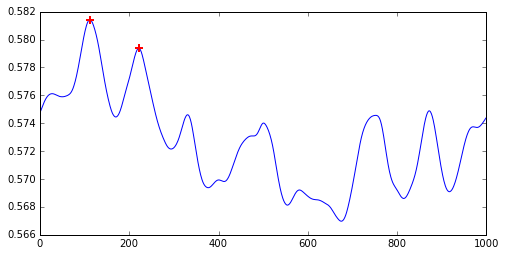

array([ 5.89299862e-01,  6.13259832e-01,  6.38001046e-01,  6.63082167e-01,
        6.88128964e-01,  7.12833792e-01,  7.36960860e-01,  7.60344287e-01,
        7.82876063e-01,  8.04483935e-01,  8.25096336e-01,  8.44623296e-01,
        8.62976540e-01,  8.80096892e-01,  8.95949933e-01,  9.10504379e-01,
        9.23732277e-01,  9.35631016e-01,  9.46229518e-01,  9.55569923e-01,
        9.63690826e-01,  9.70620746e-01,  9.76381821e-01,  9.81006636e-01,
        9.84555136e-01,  9.87108463e-01,  9.88738279e-01,  9.89487734e-01,
        9.89381472e-01,  9.88438599e-01,  9.86682828e-01,  9.84159919e-01,
        9.80946504e-01,  9.77143049e-01,  9.72868308e-01,  9.68259624e-01,
        9.63467468e-01,  9.58638428e-01,  9.53899656e-01,  9.49360693e-01,
        9.45112394e-01,  9.41212805e-01,  9.37691840e-01,  9.34571857e-01,
        9.31875173e-01,  9.29617071e-01,  9.27798778e-01,  9.26411981e-01,
        9.25444768e-01,  9.24880285e-01,  9.24701161e-01,  9.24905474e-01,
        9.25518348e-01,  

In [13]:
import quickspikes as qs

data = pd.read_csv("Data/manual.csv")
original_signal = data['Mean40'][0:1000]
#plt.show()
#plt.savefig('orgsig.png')

# First, design the Buterworth filter
N  = 2    # Filter order
Wn = 0.03 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
# Second, apply the filter
tempf = signal.filtfilt(B,A, original_signal)

#det = qs.detector(0.55, 1)
reldet = qs.detector(1, 20)
reldet.scale_thresh(tempf.mean(), tempf.std())
times = reldet.send(tempf)
print(times)

#plt.plot(tempf,'r', linewidth = '2')
_, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(tempf, 'b', lw=1)
ax.plot(times, tempf[times], '+', mfc=None, mec='r', mew=2, ms=8)
plt.show()

scipy.stats.zscore(tempf)

Experiment 1: Manual ROI Segmentation
 Time to segment: 1day (12 hours)
After calcium transients
THIS IS THE CALCULATED THRESHOLDS
0.40016707212887126
<class 'numpy.ndarray'>
[ 39 168 435 537]


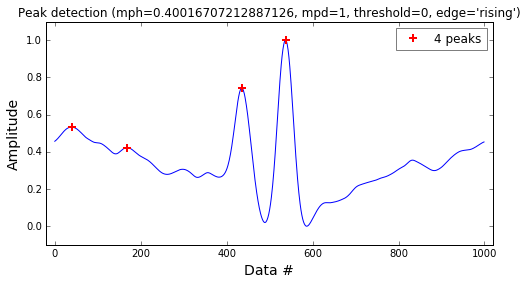

THIS IS THE CALCULATED THRESHOLDS
0.29724699996560117
<class 'numpy.ndarray'>
[ 22  80 452 964]


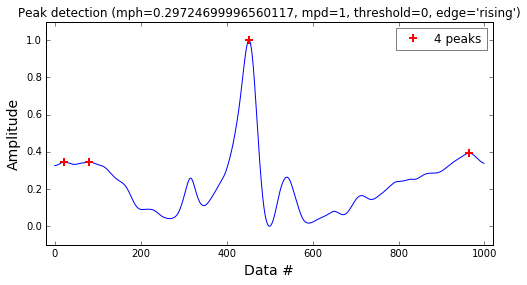

THIS IS THE CALCULATED THRESHOLDS
0.5321170149672059
<class 'numpy.ndarray'>
[ 47 172 519 619]


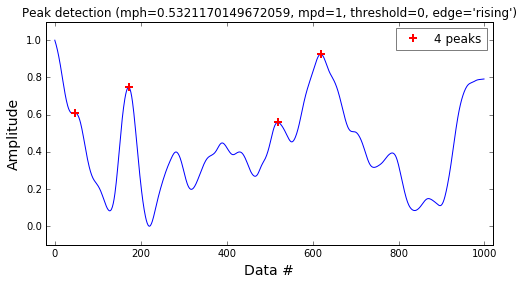

THIS IS THE CALCULATED THRESHOLDS
0.19761031363410642
<class 'numpy.ndarray'>
[504]


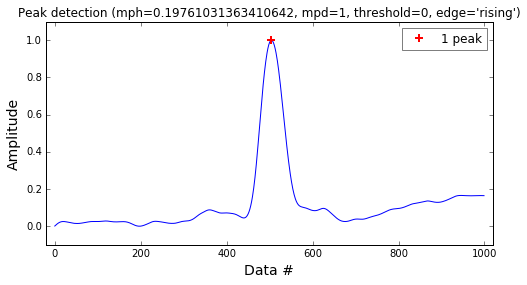

THIS IS THE CALCULATED THRESHOLDS
0.12181281568016462
<class 'numpy.ndarray'>
[241 516 854 958]


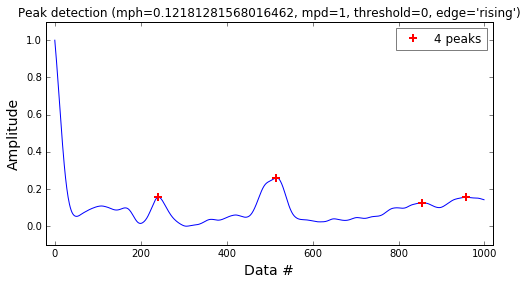

THIS IS THE CALCULATED THRESHOLDS
0.4604726214820179
<class 'numpy.ndarray'>
[493 862 962]


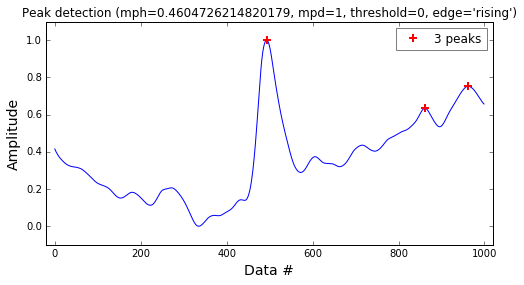

THIS IS THE CALCULATED THRESHOLDS
0.33989868996549877
<class 'numpy.ndarray'>
[75]


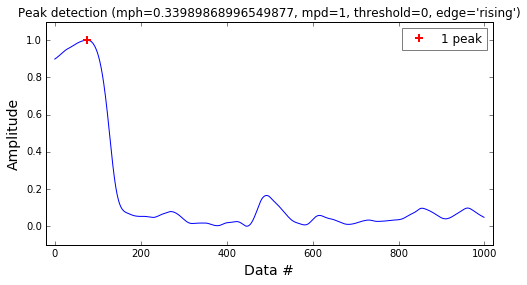

THIS IS THE CALCULATED THRESHOLDS
0.5356131169007855
<class 'numpy.ndarray'>
[240 431 462 737 827 921]


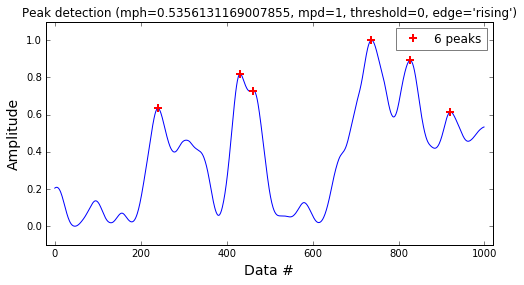

THIS IS THE CALCULATED THRESHOLDS
0.48938911404028523
<class 'numpy.ndarray'>
[ 97 184 461 727 857]


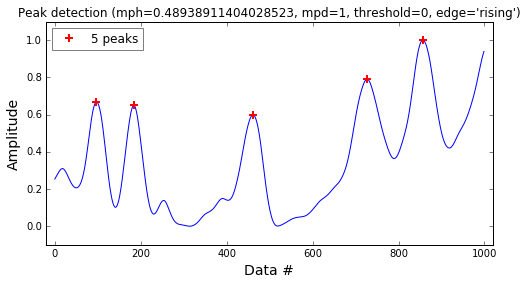

THIS IS THE CALCULATED THRESHOLDS
0.282092195389505
<class 'numpy.ndarray'>
[ 93 360 900 978]


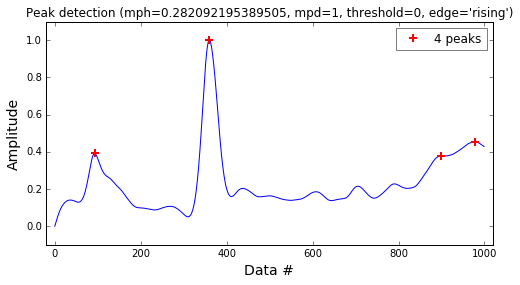

THIS IS THE CALCULATED THRESHOLDS
0.3364953132963212
<class 'numpy.ndarray'>
[347 792]


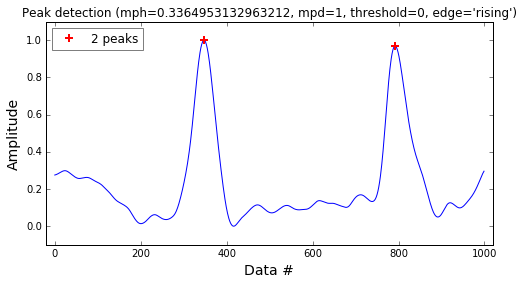

THIS IS THE CALCULATED THRESHOLDS
0.25941883352582784
<class 'numpy.ndarray'>
[462 959]


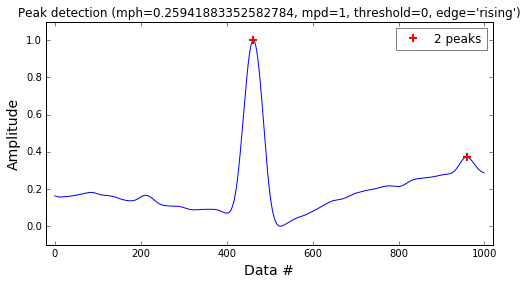

THIS IS THE CALCULATED THRESHOLDS
0.19744986435054915
<class 'numpy.ndarray'>
[ 76 460 967]


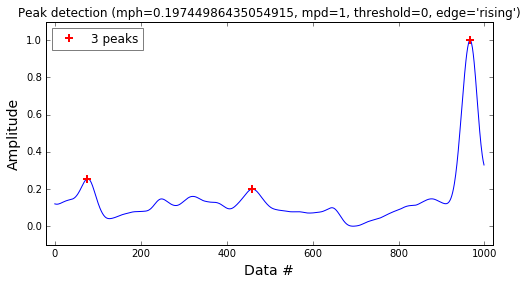

THIS IS THE CALCULATED THRESHOLDS
0.5340563915284002
<class 'numpy.ndarray'>
[ 23 221]


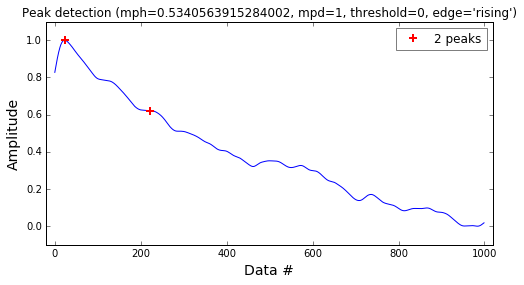

THIS IS THE CALCULATED THRESHOLDS
0.2611869558730022
<class 'numpy.ndarray'>
[ 62 421 933]


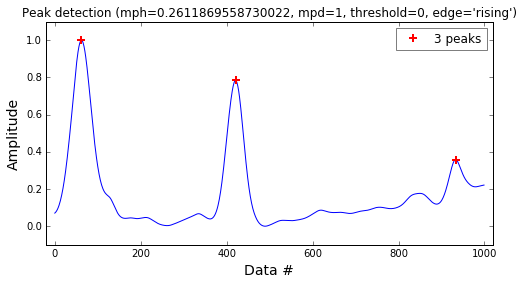

THIS IS THE CALCULATED THRESHOLDS
0.5348167281331953
<class 'numpy.ndarray'>
[975]


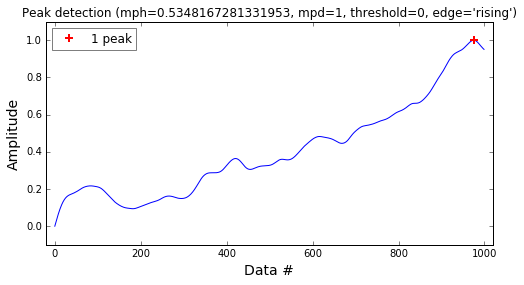

THIS IS THE CALCULATED THRESHOLDS
0.3948260901776652
<class 'numpy.ndarray'>
[518 821 864 989]


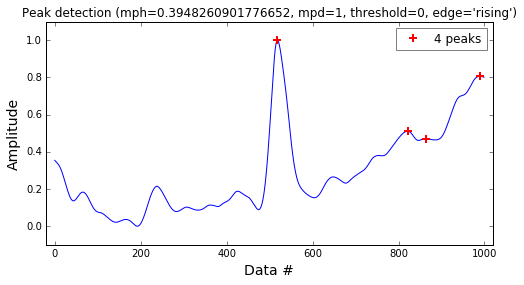

THIS IS THE CALCULATED THRESHOLDS
0.27773255769734606
<class 'numpy.ndarray'>
[121 201 334 441]


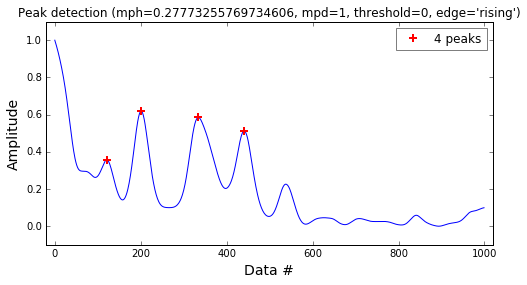

THIS IS THE CALCULATED THRESHOLDS
0.24378590903646785
<class 'numpy.ndarray'>
[ 60  85 709 980]


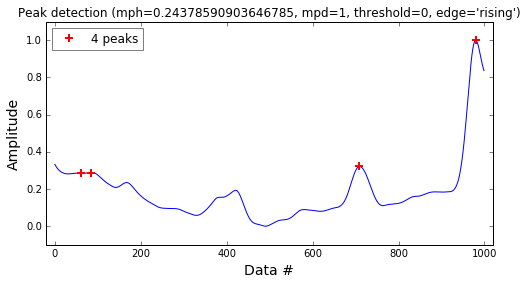

THIS IS THE CALCULATED THRESHOLDS
0.6941829512022435
<class 'numpy.ndarray'>
[ 35  75 108 169 226 871 915 980]


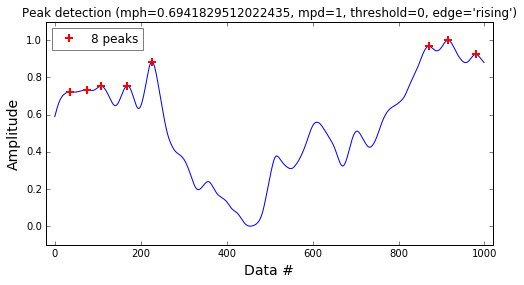

THIS IS THE CALCULATED THRESHOLDS
0.2753977460060736
<class 'numpy.ndarray'>
[247 754]


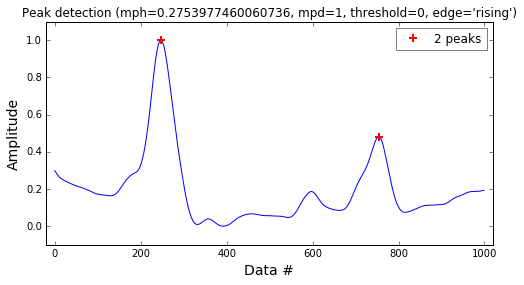

THIS IS THE CALCULATED THRESHOLDS
0.4505065056425337
<class 'numpy.ndarray'>
[ 10  49 142 937]


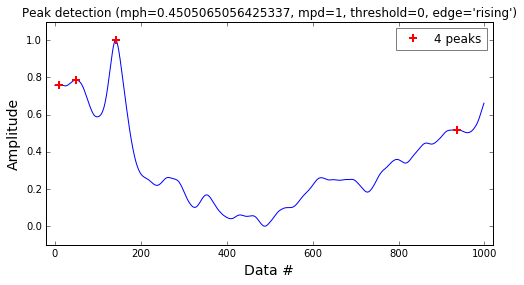

THIS IS THE CALCULATED THRESHOLDS
0.23936827418322146
<class 'numpy.ndarray'>
[150 397 992]


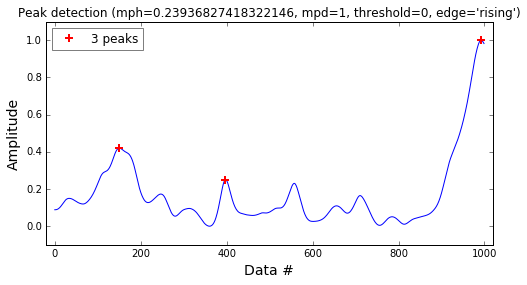

THIS IS THE CALCULATED THRESHOLDS
0.43689600961271435
<class 'numpy.ndarray'>
[350 819]


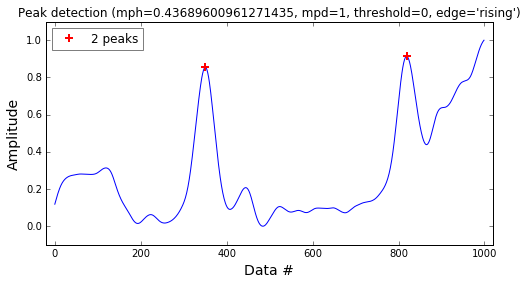

THIS IS THE CALCULATED THRESHOLDS
0.34407802220575007
<class 'numpy.ndarray'>
[212 250 433 872 959]


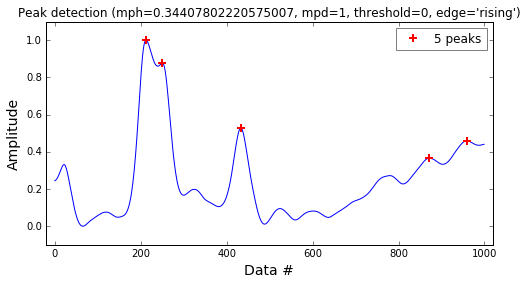

THIS IS THE CALCULATED THRESHOLDS
0.43379509630631896
<class 'numpy.ndarray'>
[ 43  66 773 920]


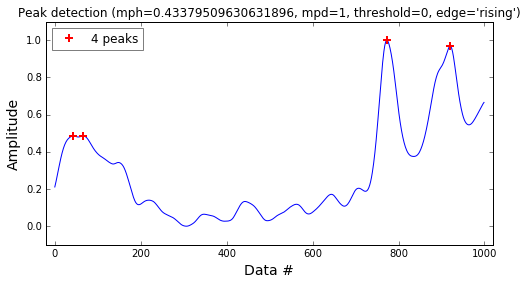

THIS IS THE CALCULATED THRESHOLDS
0.2252717672328171
<class 'numpy.ndarray'>
[247 896 952]


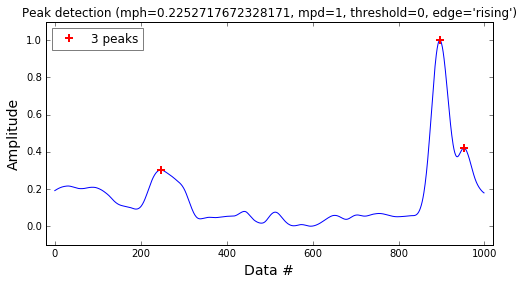

THIS IS THE CALCULATED THRESHOLDS
0.3339691290075566
<class 'numpy.ndarray'>
[248]


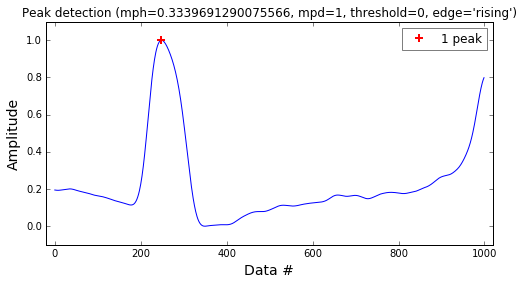

THIS IS THE CALCULATED THRESHOLDS
0.3259593829061459
<class 'numpy.ndarray'>
[401 447]


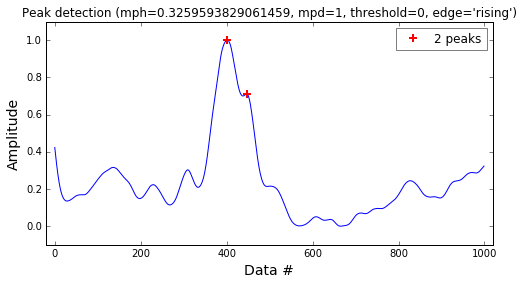

THIS IS THE CALCULATED THRESHOLDS
0.40777010469560443
<class 'numpy.ndarray'>
[ 82 264 350 826 965]


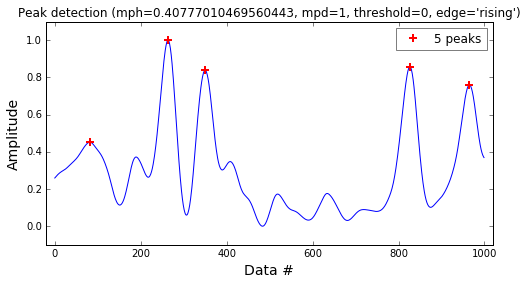

THIS IS THE CALCULATED THRESHOLDS
0.3996633667469394
<class 'numpy.ndarray'>
[144 259 352 865]


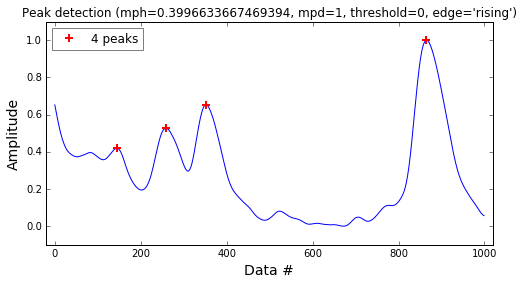

THIS IS THE CALCULATED THRESHOLDS
0.3895963650892036
<class 'numpy.ndarray'>
[ 38 749 943]


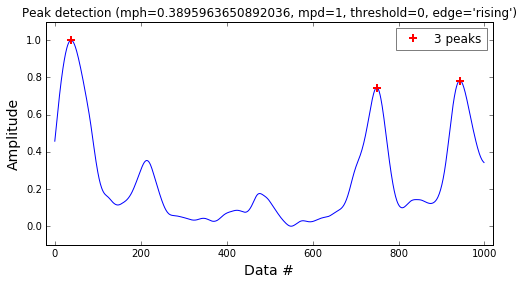

THIS IS THE CALCULATED THRESHOLDS
0.46377950000560264
<class 'numpy.ndarray'>
[ 58 183 221 885]


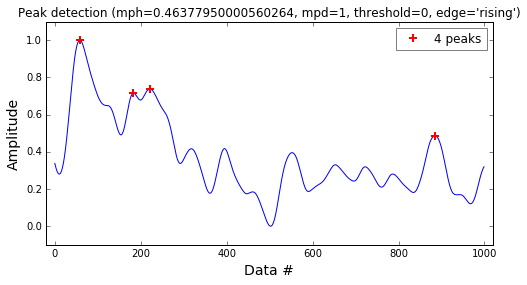

THIS IS THE CALCULATED THRESHOLDS
0.3147978896062228
<class 'numpy.ndarray'>
[250 614 785 867 904 950]


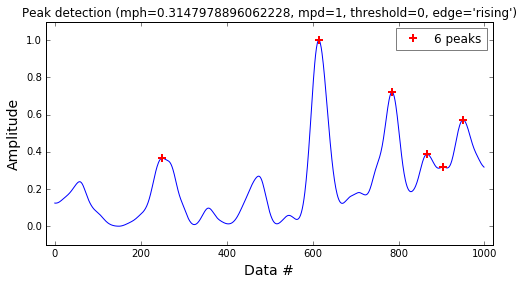

THIS IS THE CALCULATED THRESHOLDS
0.3500296007145043
<class 'numpy.ndarray'>
[536 861 895]


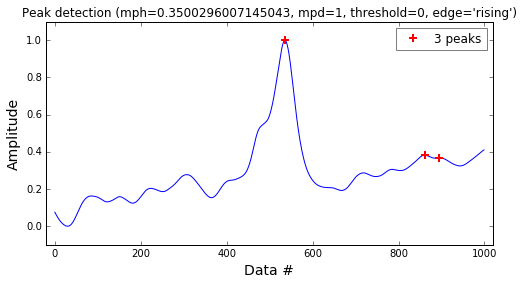

THIS IS THE CALCULATED THRESHOLDS
0.2362212276150894
<class 'numpy.ndarray'>
[95]


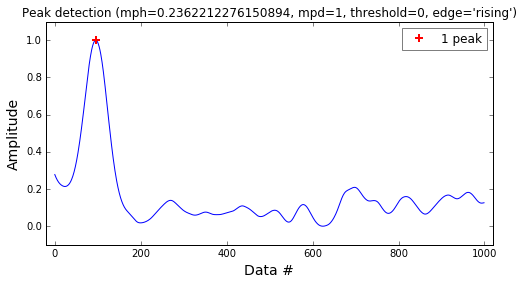

THIS IS THE CALCULATED THRESHOLDS
0.5107517447372846
<class 'numpy.ndarray'>
[ 27 112 221 331 752 872]


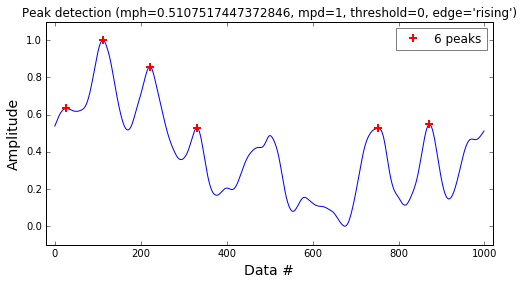

 Number of ROI detected originally:  40
 Number of viable ROI detected according to circularity and feret number:  37
 Number of cells with calcium transients detected:  32
 Signal to noise ratio of transients detected:  3.028625216742821


/home/pelonomi/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  This is separate from the ipykernel package so we can avoid doing imports until


In [201]:
print("Experiment 1: Manual ROI Segmentation")
print(" Time to segment: 1day (12 hours)")
size_shape_roi, calciumtrace_roi = perform_analysis("Data/manual.csv")

In [125]:
dpath = "Data/unetstd_ROInames.txt"
print("These are the ROI of correct size and shape")
print(len(confirm_roi_name(dpath, size_shape_roi)))

print("These are the ROI That are correct size, shape and have Ca trace")
print(len(confirm_roi_name(dpath, calciumtrace_roi)))


These are the ROI of correct size and shape
37
These are the ROI That are correct size, shape and have Ca trace
32


In [24]:
print("\nExperiment 2: Plain old thresholding work flow with gaussian filter")
print(" Time to segment: 5min ")
perform_analysis("Data/thresh.csv")

print("\nExperiment 3: Weka Segmentation")
print(" Time to segment: 2min 20s")
perform_analysis("Data/weka.csv")

print("\nExperiment 4: ICA")
print(" Time to segment: 35min ")
perform_analysis("Data/ica.csv")

print("\nExperiment 5a: Unet2DS on mean summary image")
print(" Time to segment: 2s ")
perform_analysis("Data/unet_mean.csv")

Experiment 1: Manual ROI Segmentation
 Time to segment: 1day (12 hours)


/home/pelonomi/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  This is separate from the ipykernel package so we can avoid doing imports until


 Number of ROI detected originally:  40
 Number of viable ROI detected according to circularity and feret number:  37
 Number of cells with calcium transients detected:  32
 Signal to noise ratio of transients detected:  3.028625216742821

Experiment 2: Plain old thresholding work flow with gaussian filter
 Time to segment: 5min 
 Number of ROI detected originally:  58
 Number of viable ROI detected according to circularity and feret number:  28
 Number of cells with calcium transients detected:  26
 Signal to noise ratio of transients detected:  3.051997582814371

Experiment 3: Weka Segmentation
 Time to segment: 2min 20s
 Number of ROI detected originally:  126
 Number of viable ROI detected according to circularity and feret number:  24
 Number of cells with calcium transients detected:  24
 Signal to noise ratio of transients detected:  2.306168503353214

Experiment 4: ICA
 Time to segment: 35min 
 Number of ROI detected originally:  44
 Number of viable ROI detected according to c


Experiment 5b: Unet2DS on standard deviation summary image
 Time to segment: 2s 
After calcium transients


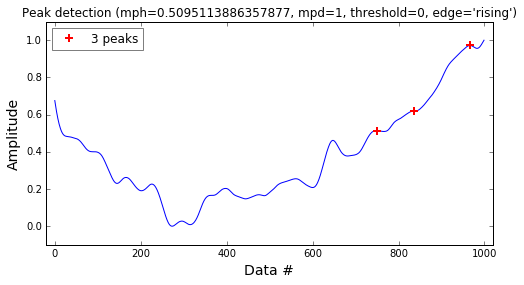

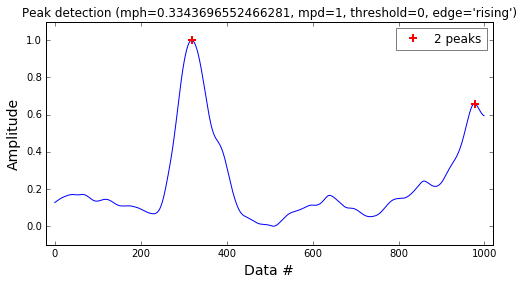

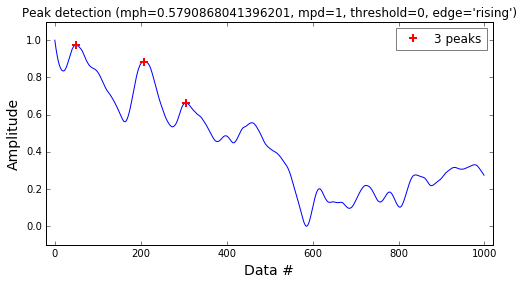

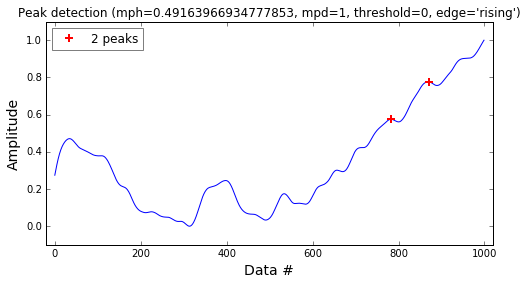

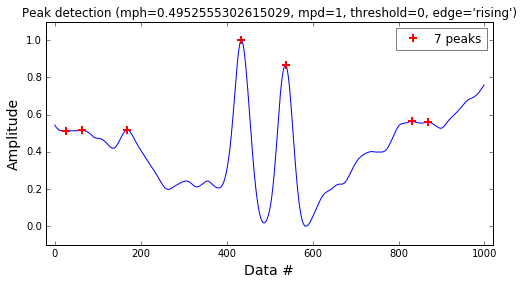

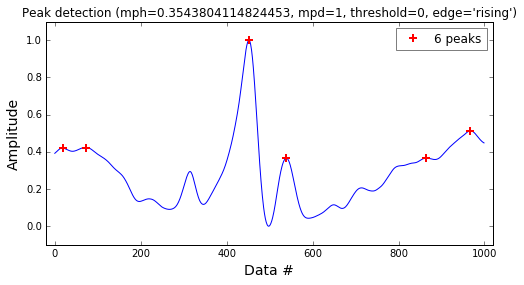

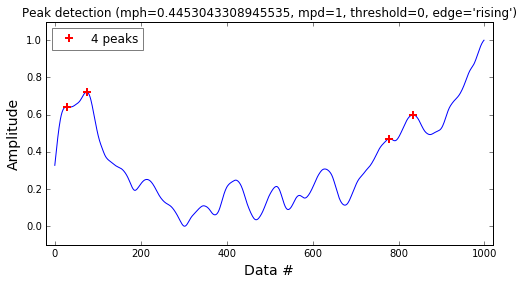

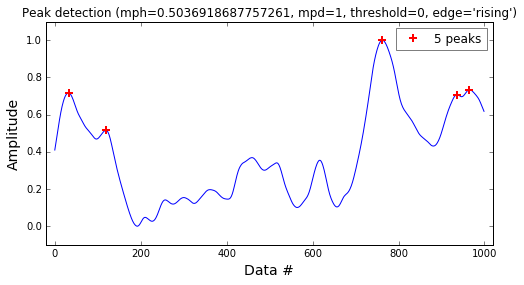

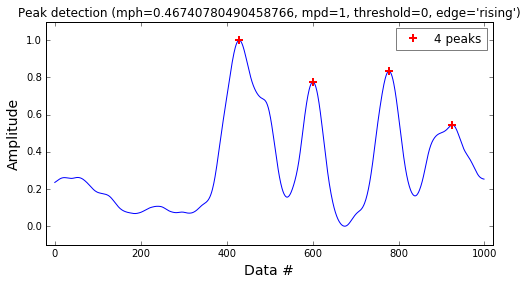

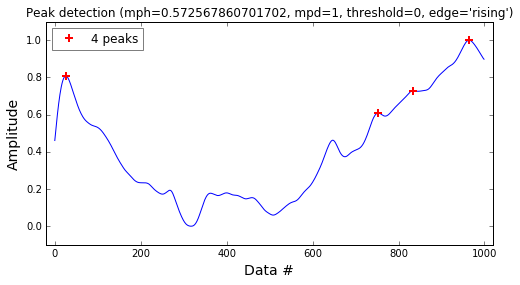

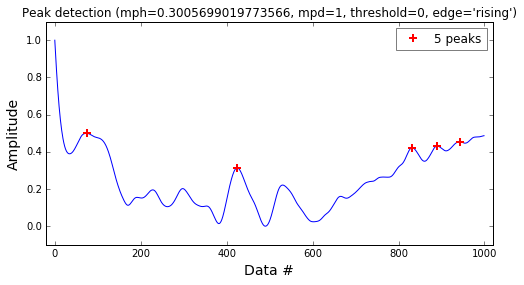

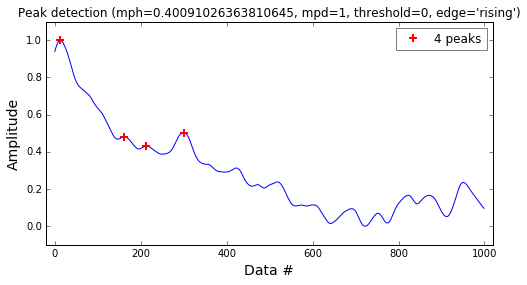

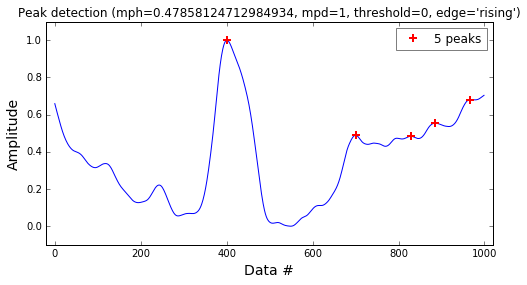

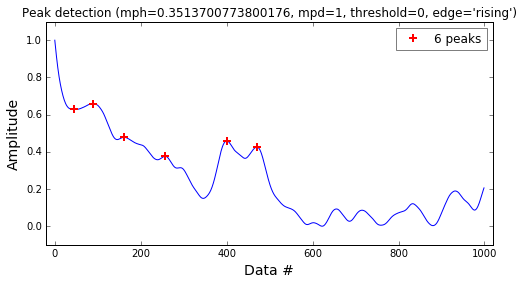

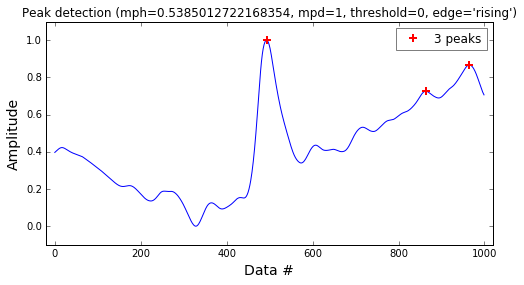

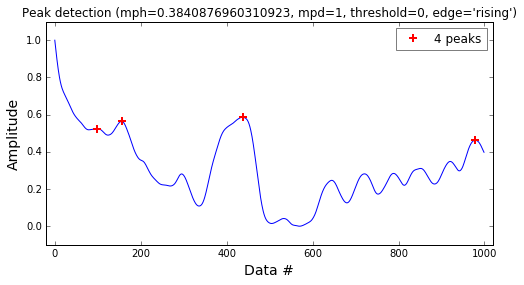

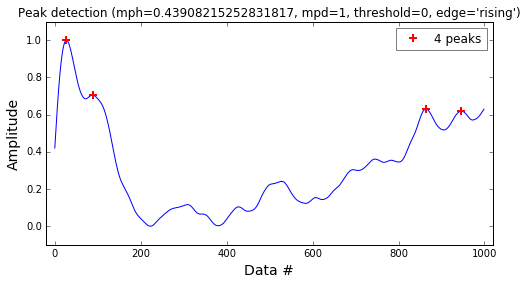

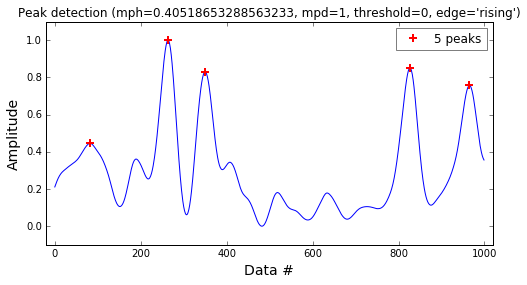

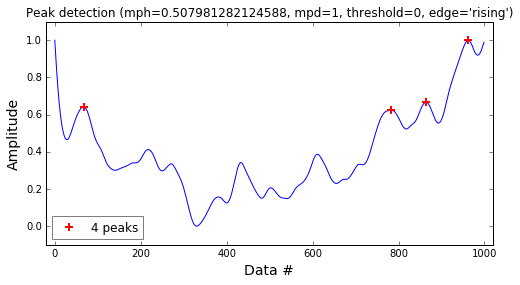

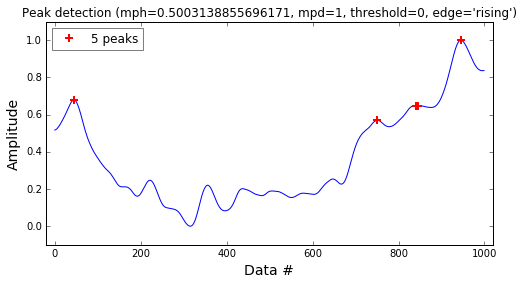

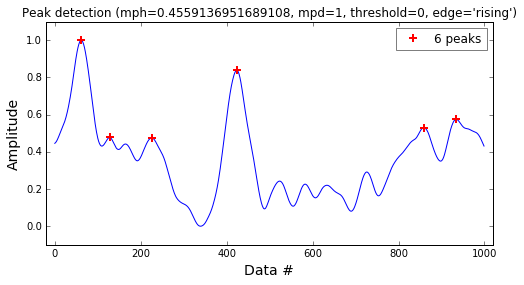

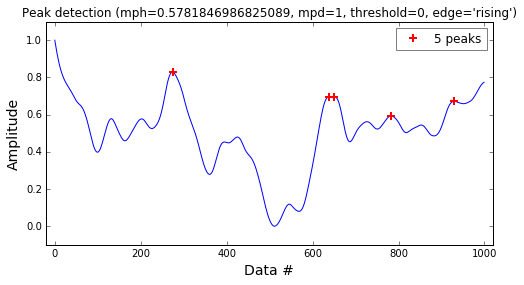

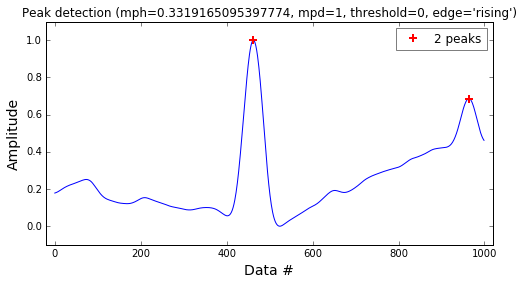

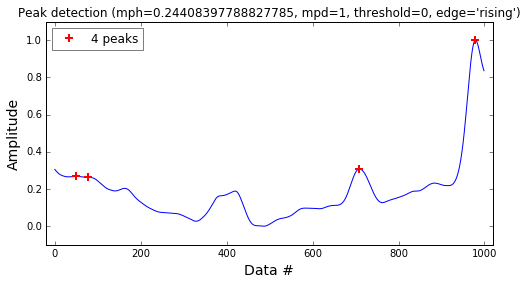

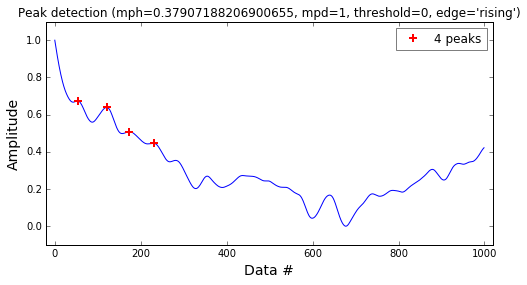

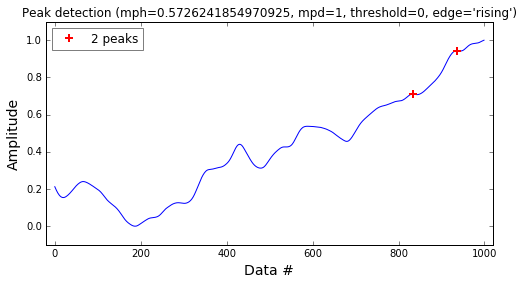

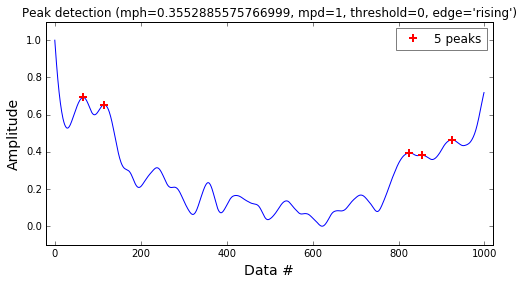

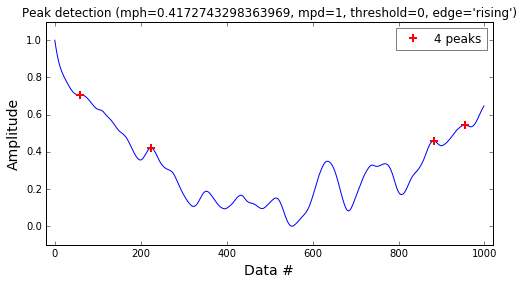

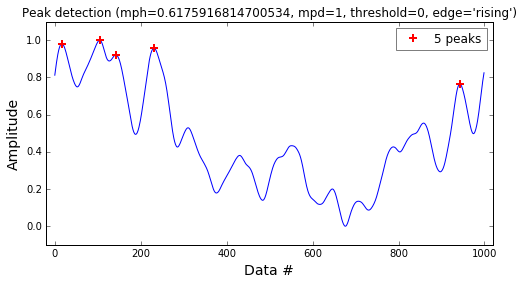

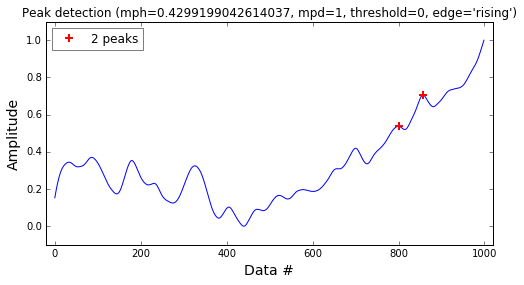

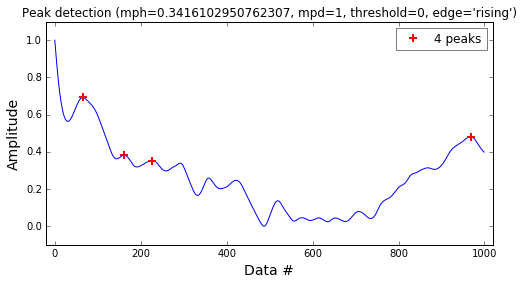

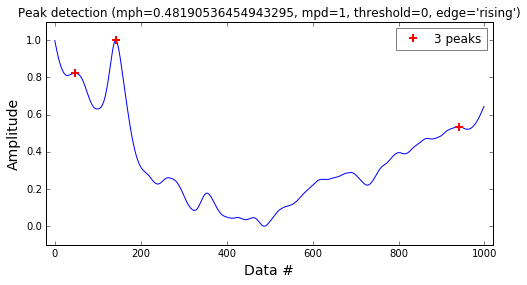

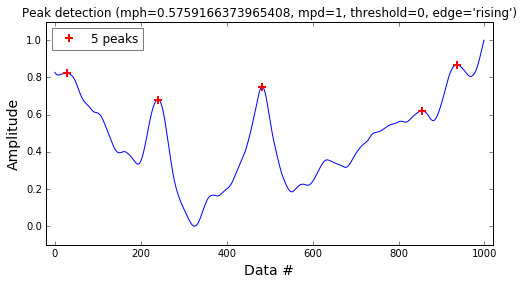

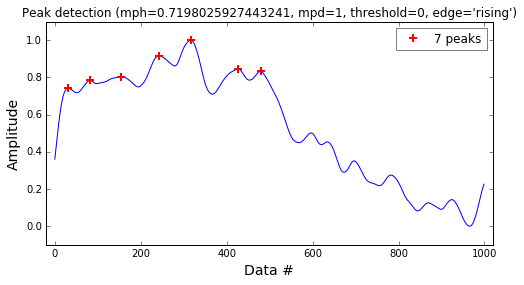

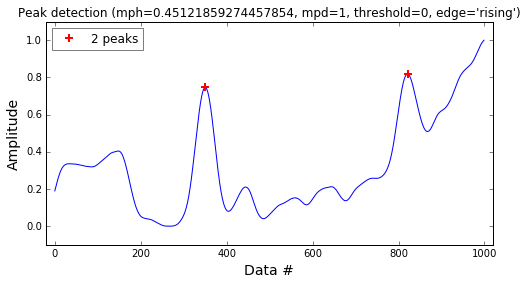

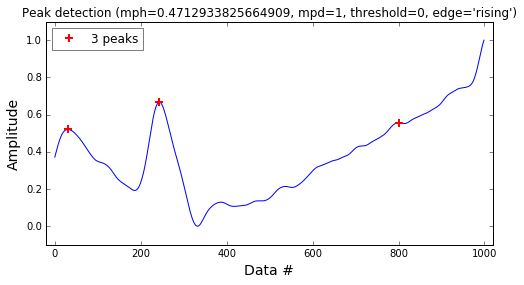

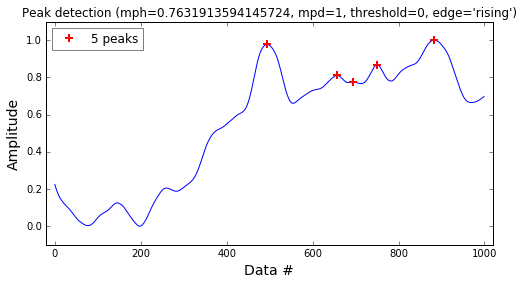

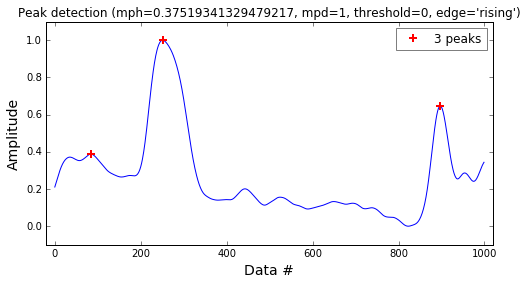

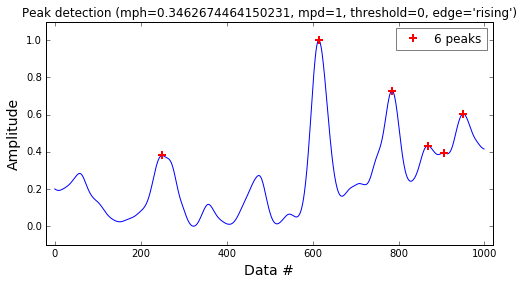

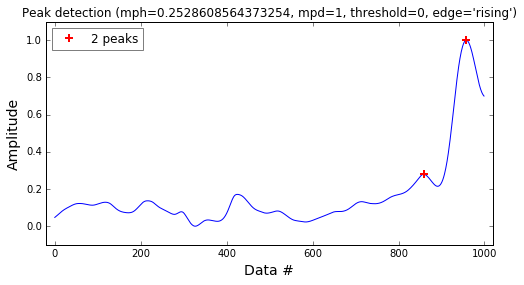

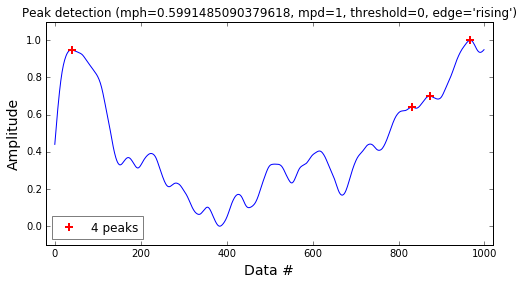

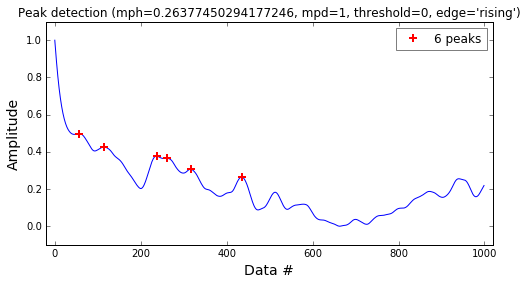

 Number of ROI detected originally:  43
 Number of viable ROI detected according to circularity and feret number:  42
 Number of cells with calcium transients detected:  42
 Signal to noise ratio of transients detected:  2.122420963706292


/home/pelonomi/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  This is separate from the ipykernel package so we can avoid doing imports until


(['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '43'],
 ['Mean1',
  'Mean2',
  'Mean3',
  'Mean4',
  'Mean5',
  'Mean6',
  'Mean7',
  'Mean8',
  'Mean9',
  'Mean10',
  'Mean11',
  'Mean12',
  'Mean13',
  'Mean14',
  'Mean15',
  'Mean16',
  'Mean17',
  'Mean18',
  'Mean19',
  'Mean20',
  'Mean21',
  'Mean22',
  'Mean23',
  'Mean24',
  'Mean25',
  'Mean26',
  'Mean27',
  'Mean28',
  'Mean29',
  'Mean30',
  'Mean31',
  'Mean33',
  'Mean34',
  'Mean35',
  'Mean36',
  'Mean37',
  'Mean38',
  'Mean39',
  'Mean40',
  'Mean41',
  'Mean42',
  'Mean43'])

In [124]:
print("\nExperiment 5b: Unet2DS on standard deviation summary image")
print(" Time to segment: 2s ")
perform_analysis("Data/unet_std.csv")

Okay so, the most frequently used tools are Manual segmentation, Thresholding based algorithms, K means which I actually have not done but should do, and then I checked out some new things that arent so popular yet the Trainable Weka Segmentation Algorithm and ICA

The times shown here do not take into account the initial pre processing time of the ration image. For example, it takes approximately 2min 50s to just load the images into image J. From there the combined times of subtraction of the F380 from the F340 and then division of the F380 takes a further 35s which brings the total pre processing time to 3min 25s. As the ratio image is used for each of the methods explored, the true time would be refelected by the time given in the result in addition to this pre processing time.

Both Thresholding and Weka Segmentation have very poor repeatability. Conventional thresholding methods have so many different workflows that it takes a long time of playing around to determine which processing procedures should be performed on the image and in what oder. He it is reflected that the segmentation time is 5 min which is a true indication of how long it takes to segement an image once you have deciuded the processing flow. It does nnot reflect the many hours it would take you to explore which flows work best. It also does not reflect the fact that the flow will change accroding to the type of image you are dealing with and so the processing time (as well as the time to actaully figure out that process) will change depending on the image in question. This can be suitable as the process can be adapted to fit any type of image, but it is not ideal. The Weka Segmentation algorithm is dependant on the regions manually selected by a user each time. This means that, that a user would have to select the very same regions every single time to get the same results. This is highly unlikely and is not even possible when different images need to be segmented. Thus again, repeatability is poor.

Each of the methods explored give a dramatic decrease in. ICA does really well. But I think I need to improve my calcium trace detection method before I can really say so. Considering that the most truthful solution up to this point is considered to be the manual segemntation, I am going to compare the binary images and see how different they are. It is also noted that manua segmentation is limited to eliptical shapes and so results in a higher SNR because the area of interest is not completely accurate.

The ICA algorithm also kind of cheats because you tell it how many cells you are expecting as well as kind of what size you are expecting. So although it performs really well it does not actually proide the type of autonomy that we are looking for. We also need to check out the repeatability of it.

I am still going to try out my new method though.

Things to research further
1. Repeatability of ICA
2. Compare ICA binary image with manual binary image to see how they compare
3. Fix peak detection algorithm

Hear we make nice pictures for report writing and shit 

False
[]


/home/pelonomi/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
/home/pelonomi/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


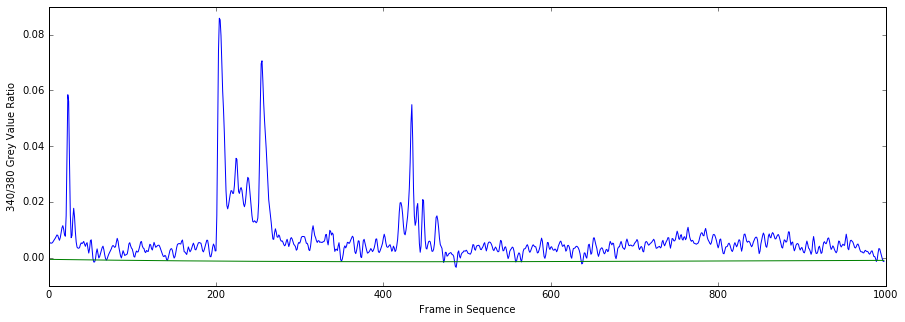

False
[]


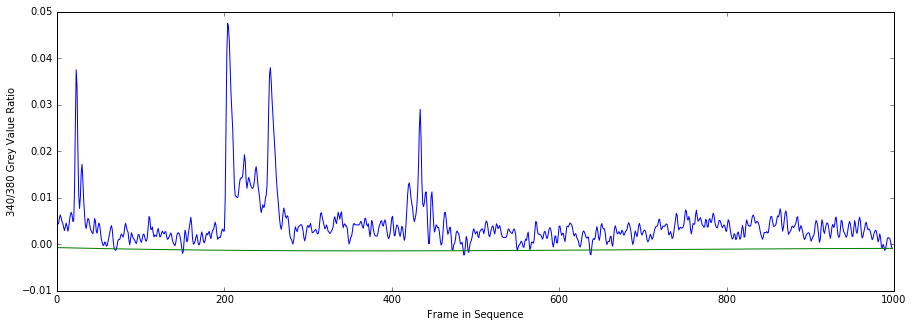

In [92]:
import peakutils
import numpy as np
from sklearn.preprocessing import normalize


data340 = pd.read_csv("/home/pelonomi/Desktop/thesis_images/roiregions/340_manual.csv")
data380 = pd.read_csv("/home/pelonomi/Desktop/thesis_images/roiregions/380_manual.csv")
cell_no =26

data340_tsu = pd.read_csv("/home/pelonomi/Desktop/thesis_images/roiregions/340_tsunet.csv")
data380_tsu = pd.read_csv("/home/pelonomi/Desktop/thesis_images/roiregions/380_tsunet.csv")
cell_no_tsu =10


def plot_signal(signal_340, signal_380, cell_no):
    data340cell = signal_340['Mean'+str(cell_no)][1:1000]
    data380cell = signal_380['Mean'+str(cell_no)][1:1000]
    filtval = 6
    h = signal.hanning(filtval)

    temp340 = np.convolve(data340cell, h)
    temp380 = np.convolve(data380cell, h)

    ratio = np.divide(temp340,temp380)
    print(np.isnan(ratio[1:1000]).any())
    print(np.argwhere(np.isnan(ratio[1:1000])))

    ratio = ratio[1:1000]

    baseline_values = peakutils.baseline(ratio[0:1000])


    intensity_corrected = ratio-baseline_values
    baseline_values = peakutils.baseline(intensity_corrected)
    fig = plt.figure(figsize=(15,5))
    plt.xlabel("Frame in Sequence")
    plt.ylabel("340/380 Grey Value Ratio")
    plt.axis()
    
    plt.plot(intensity_corrected)
    plt.plot(baseline_values)
    plt.show()
    return intensity_corrected

intensity_corrected = plot_signal(data340, data380, cell_no)
#detect_peaks(intensity_corrected,mpd = 1, mph = 0.01, show=True)

intensity_corrected = plot_signal(data340_tsu, data380_tsu, cell_no_tsu)
#detect_peaks(intensity_corrected,mpd = 1, show=True)

In [90]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

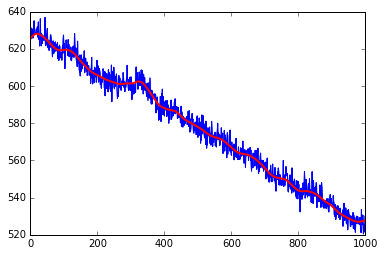

In [96]:
# read in data
data = pd.read_csv("/home/pelonomi/Desktop/thesis_images/340.csv")
original_signal = data['Mean1'][0:1000]
original_signal.plot()
#plt.show()
#plt.savefig('orgsig.png')

# First, design the Buterworth filter
N  = 2    # Filter order
Wn = 0.03 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
# Second, apply the filter
tempf = signal.filtfilt(B,A, original_signal)

# FILTERED SIGNAL
#plt.plot(tempf)
#plt.savefig('filtsig.png')
#plt.show()
# NOISE
#plt.plot(original_signal-tempf)
#plt.savefig('noisesig.png')
#plt.show()

plt.plot(original_signal, 'b')
plt.plot(tempf,'r', linewidth = '2')

plt.show()

/home/pelonomi/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


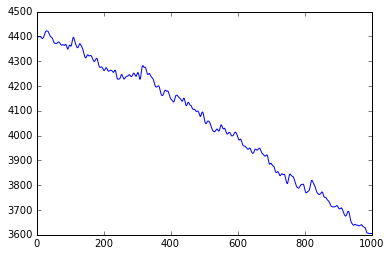

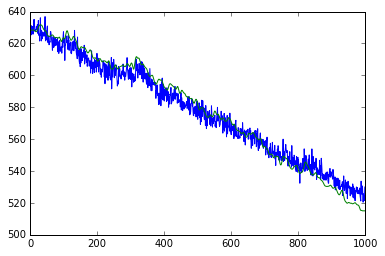

1001
1000


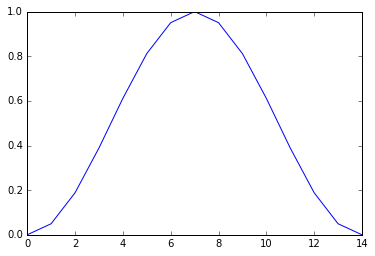

ValueError: operands could not be broadcast together with shapes (1000,) (1001,) 

In [15]:
from sklearn.preprocessing import normalize
filtval = 15

h = signal.hanning(filtval)
temp = np.convolve(data['Mean7'][0:1000], h)
filted = temp[filtval:1000]
padval = round(filtval/2)
correct_length = np.pad(filted, (padval, padval),'edge')
plt.plot(correct_length)
plt.show()
plt.plot(original_signal[0:1000])
scale_factor = (filtval-1)/2
plt.plot(correct_length/scale_factor)

plt.savefig('hanningfilt.png')
plt.show()
print(len(correct_length))
print(len(original_signal))
plt.plot(h)
plt.show()
trace = original_signal[0:1000]
tempf = correct_length/scale_factor
noise = np.subtract(trace, tempf)
plt.plot(noise)

In [ ]:
# this is the normalising step
# size of hanning is number of seconds
from sklearn.preprocessing import normalize

x = tempf
newth = (x - x.min()) / (x.max() - x.min())
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(data['Mean3'][1:1000])
axarr[1].plot(newth)


In [ ]:
filtval = 45
h = signal.hanning(filtval)
temp = np.convolve(data['Mean7'][1:1000], h)
filted = temp[filtval:999]
plt.plot(filted)
plt.savefig('hanningfilt.png')
plt.show()

In [ ]:
filtval = 30
h = signal.hanning(filtval)
temp = np.convolve(data['Mean7'][1:1000], h)
filted = temp[filtval:999]
plt.plot(filted)
plt.savefig('hanningfilt25.png')
plt.show()

In [ ]:
filtval = 60
h = signal.hanning(filtval)
temp = np.convolve(data['Mean7'][1:1000], h)
filted = temp[filtval:999]
plt.plot(filted)
plt.savefig('hanningfilt55.png')
plt.show()